# OSPF Service Provider Routing with Netbox and ____

# WIP...

* Not covering notes for all the basics as this is for JNCIP level OSPF, but still some review added in notes
* All 'C-Style code' in the notes is just pseudo-code to get an idea of the structures used -- I find these easier to read than diagrams. These were mostly generated by ChatGPT for me (sometimes with minor modifications).

### Notes
1) General Review
2) LSAs 
3) OSPF Process 
4) OSPF Authentication 
5) OSPFv3

### Lab Configurations and Examples
1) Topology
2) Lab Setup with Netbox

---

## 1) General Review

```
# Basic Config
set routing-options router-id 10.1.1.1

set protocols ospf area 0.0.0.0 interface ge-0/0/x.0 interface-type p2p
set protocols ospf area 0.0.0.0 interface ge-0/0/x.0 metric 100 
set protocols ospf area 0.0.0.0 interface lo0.0

# Multiple address configured on an interface and you only want one in OSPF?
# Just use the address instead of the interface name:
set protocols ospf area 0.0.0.0 interface 10.2.2.2

set protocols ospf area 0.0.0.1 interface ge-0/0/y.0
set protocols ospf area 0.0.0.1 nssa

set protocols ospf area 0.0.0.2 interface ge-0/0/y.0
set protocols ospf area 0.0.0.2 stub
```

* DR Election in Juniper:
    * Non-Deterministic; 40 second election period
    * Highest Priority (128 default)
    * Highest Router-ID
    * Just set `interface-type p2p` where possible to avoid where possible

* Router-ID Election
    * Manual   <---Just always do this...make life easy
    * First interface of the router to come online, normally the loopback <--Don't let this happen - assign the router-id manually
        * If first interface to come up, it uses the numerically lowest non 127/8 IP

* Packet Types
    * Hello, DBDs, LSR, LSU, LSA 

```
// All OSPF packets use the same header fields
struct ospf_header {
    uint8_t version;         // OSPF version number
    uint8_t type;            // OSPF packet type (4 for LSU)
    uint16_t packet_length;  // Length of the packet
    uint32_t router_id;      // Router ID
    uint32_t area_id;        // Area ID
    uint16_t checksum;       // Checksum of the entire OSPF packet
    uint16_t autype;         // Authentication type
    uint64_t authentication; // Authentication data (64 bits)
}
```

---

## 2) LSAs

* LSA Overview
    * Max Age limit 3600 seconds
        * Junos refreshes every 3000 seconds by default
        * A single LSU packet can contain multiple LSA packets
    * Other LSA Types
        * Type 6 Group Membership (used in Multicast OSPF)
        * Type 8 External Attributes (Used to tunnel attributes to other protocols)
        * Type 9-11 Opaque LSAs
            * Type 9 used for Graceful Restart 
                * Link-Local scope
            * Type 10 used for MPLS TE
                * Area scope
        * Types 6, 8 and 11 are not supported by Junos
        
#### OSPF LSA Header (Common for all LSAs)
```
struct ospf_lsa_header {
    uint16_t age;                // LSA age
    uint8_t options;             // E-bit (position 7) set in all external LSAs; P-bit (position 5) set in all NSSA External LSAs
    uint8_t type;                // LSA type (1 = Router LSA, 2 = Network LSA, etc.)
    uint32_t lsa_id;             // LSA ID (depends on type)
    uint32_t advertising_router; // Router ID of the advertising router
    uint32_t sequence_number;    // Sequence number for versioning
    uint16_t checksum;           // LSA checksum
    uint16_t length;             // Length of the LSA (including header and body)
}
```

#### LSU
```
struct ospf_lsu {
    struct ospf_header header;  // OSPF common header
    uint32_t num_lsas;          // Number of LSAs in this packet
    uint8_t lsa_data[];         // Variable-length LSAs (Router LSA, Network LSA, etc.)
}
```

### Router LSA (Type 1)

* local-area flood scope
* `show ospf database router extensive`

```
// Router LSA (Type 1)
struct ospf_router_lsa {
    struct ospf_lsa_header header;       // Common LSA header
    uint8_t flags;                       // LSA Flags (B = ABR, E = ASBR, V = Virtual)
    uint8_t flags;                       // Flags (B-bit:P8 (ABR), E-bit:P7 (ASBR), V-bit:P6 (Virtual Link)) 
    uint8_t reserved;                    // Unused, set to 0
    uint16_t link_count;                 // Number of link descriptors
    struct ospf_router_lsa_link links[]; // Variable-length list of links
} 

struct ospf_router_lsa_link {
    uint32_t link_id;     // Link ID (depends on link type)
    uint32_t link_data;   // Link Data (Interface IP, Subnet Mask, etc.)
    uint8_t type;         // Link Type (1 = P2P, 2 = Transit, 3 = Stub, 4 = Virtual)
    uint8_t num_tos;      // Number of TOS entries (deprecated, set to 0)
    uint16_t metric;      // Cost of this link

    // ---------------------------------------------------------------- //
    // Not really sure if these are used any more. I will see in the PCAPs :)
    // ---------------------------------------------------------------- //
    uint8_t num_mt_entries; // Number of MT-ID entries (0 if no MTR)
    struct {
        uint8_t mt_id;          // Multi-Topology ID
        uint16_t mt_metric;     // Metric for this MT-ID
    } mt_entries[];             // Variable-length list of MT-ID entries
    uint32_t additional_data;   // Unused
    // ---------------------------------------------------------------- //
    // ---------------------------------------------------------------- //
    
}


+-------------------------------+--------------------------------+------------------------------+
| Link Type                     | Link ID                        | Link Data                    |
+-------------------------------+--------------------------------+------------------------------+
| Point-to-Point (P2P) (Type 1) | Neighbor’s Router ID           | Local Router’s Interface IP  |
|                               |                                | Address                      |
+-------------------------------+--------------------------------+------------------------------+
| Transit (Type 2)              | Designated Router’s Interface  | Local Router’s Interface IP  |
| (supports M/A Network Links)  | IP Address                     | Address                      |
+-------------------------------+--------------------------------+------------------------------+
| Stub (Type 3)                 | Network Number                 | Subnet Mask                  |
| (Supports P2P, Passive,       |                                |                              |
| and Loopback Interfaces)      |                                |                              |
+-------------------------------+--------------------------------+------------------------------+
| Virtual Link (Type 4)         | Neighbor’s Router ID           | Local Router’s Interface IP  |
|                               |                                | Address                      |
+-------------------------------+--------------------------------+------------------------------+

```

### Nework LSA (Type 2)

* generated by the DR
* local-area flood scope
* LSA ID is the address on the DR interface
* `show ospf database network extensive`

```
// Network LSA (Type 2)
struct ospf_network_lsa {
    struct ospf_lsa_header header; // Common LSA header
    uint32_t network_mask;         // Subnet mask of the network
    uint32_t attached_routers[];   // List of Router IDs connected to this network (variable length)
}
```


### Nework Summary LSA (Type 3)

* area-scope; originated by ABRs
* LSA ID is the destination network
* Adv Router is the IP address of the ABR
* `show ospf database netsummary extensive`

```
// Summary LSA (Type 3) with MT-ID Support
struct ospf_summary_lsa {
    struct ospf_lsa_header header; // Common LSA header
    uint32_t network_mask;         // Subnet mask of the advertised prefix
    uint8_t metric[3];             // 24-bit metric value (cost to reach the network)
    uint8_t options;               // OSPF options (E, MC, NP bits)
    uint8_t num_mt_entries;        // Number of MT-ID entries (0 if MTR is disabled)
    
    // Variable-length Multi-Topology entries
    struct {
        uint8_t mt_id;             // Multi-Topology ID
        uint8_t mt_metric[3];      // 24-bit metric for this topology
    } mt_entries[];                // Flexible array for MT-ID metrics
}
```

### AS Boundary Router Summary LSA (Type 4)
* network mask is always set to 0.0.0.0
* metric is the cost to reach the ASBR
* LSA ID is the ASBR Router ID
* `show ospf database asbrsummary extensive`

```
struct ospf_asbr_summary_lsa {
    struct ospf_lsa_header header; // Common LSA header
    uint32_t network_mask;         // Always 0.0.0.0 for ASBR Summary LSA
    uint8_t metric[3];             // 24-bit metric (cost to reach the ASBR)
    uint8_t options;               // OSPF options (E, MC, NP bits)
    uint8_t num_mt_entries;        // Number of MT-ID entries (0 if no MTR)
    
    // Variable-length Multi-Topology entries
    struct {
        uint8_t mt_id;             // Multi-Topology ID
        uint8_t mt_metric[3];      // 24-bit metric for this topology
    } mt_entries[];                // Flexible array for MT-ID metrics
}
```


### External LSA (Type 5)

* `show ospf database external extensive`
* Domain scope (non-stub areas)
* LSA-ID: external network prefix
* Adv Routers: Router-ID of the ASBR
* E-bit: type-1 or type-2 (0; the default)
    * E-1: cummulative
    * E-2: constant
    * E-1 routes are preferred over E-2 routes 


```
// AS External LSA (Type 5) with MT-ID Support
struct ospf_as_external_lsa {
    struct ospf_lsa_header header; // Common LSA header
    uint32_t network_mask;         // Subnet mask of the advertised prefix
    uint8_t metric[3];             // 24-bit metric (OSPF cost)
    uint8_t flags;                 // E-bit (1 = Type 2 metric, 0 = Type 1 metric)
    uint32_t forwarding_address;   // Next-hop address (if not 0.0.0.0); 0.0.0.0 represents the ASBR itself
    uint32_t external_route_tag;   // Used for policy-based routing
    uint8_t num_mt_entries;        // Number of MT-ID entries (0 if no MTR)
    
    // Variable-length Multi-Topology entries
    struct {
        uint8_t mt_id;             // Multi-Topology ID
        uint8_t mt_metric[3];      // 24-bit metric for this topology
    } mt_entries[];                // Flexible array for MT-ID metrics
}
```

### NSSA LSA (Type 7)

* Generated within a NSSA (or totally NSSA) area and converted to Type 5 by the ABRs
* Uses same format as the Type 5. If the next-hop of the prefix is known internally, that will be used for the forwarding-address field
    * Translated to Type-5 by the ABR with **highest router-ID**
* `show ospf database external extensive`


## OSPF Database Protection
* Protects the LSDB from being overwhelmed...
* **BUT** -- Uwaga! Uwaga! --kills all adjancencies if exceeded!!!
    * set `warning-only` to avoid this
* Useful between PE and CE routers peering via OSPF

```
set protocols ospf database-protection maximum-lsa 1000
set protocols ospf database-protection warning-only
```

---


### 3) OSPF Process

* SPF Algo uses LSDB, Candidate DB, Tree DB
* Cost/Metric
    * `set protocols ospf reference-bandwidth 100g` (default 10^8)
    * `set protocols ospf area 0.0.0.0 interface ge-0/0/x.0 metric xx`
    * Uses cost of **out-going** interface; cost might not be considered the same on both sides of a link
* `Overload`
    * set metric to 65535 for all transit links on the router but continue to advertise and flood LSAs
    * can be used with a timer
    * useful for maintenance
* import statement can only affect Type 5 and Type 7 routes; not recommended to use; remember, floods everywhere within an area...
* Mandatory hold-down after 3 consecutive runs of SPF
    * 5 second default
    * Prevents churn in unstable network
    * Can set from 2,000 to 20,000 ms (`set protocols ospf spf-options holddown`) 
* 200 ms delay after topology change to run SPF
    * Can set from 50 to 8000 ms(`set protocols ospf spf-options delay`)
    * Best to set slightly higher than worst possible propagation delay in the network
* Preference Order:
    1) Intra-Area Links - First as E1
    2) Inter-Area Links
    3) External Type E1
    3) External Type E2


### 4) OSPF Authentication
* None, Simple, MD5
    * Easy to pcap the simple password
    * md5 is recommended rather than simple
        * key-value between 0 and 255 required
* `show ospf interface detail` to verifiy 

```
# simple
set protocols ospf area 0.0.0.0 interface ge-0/0/x.0 authentication simple-password "$9$aesdfadsfasdfaasdfasdfasd"

# md5
set protocols ospf area 0.0.0.0 interface ge-0/0/x.0 authentication md5 30 key "$9$asdfasdf"
```

### 5) OSPFv3
* RFC 5340
* Protocol processing per link rather than per subnet
* Make sure you set a Router-ID
* Can be used for IPv4 and IPv6, but must enable IPv6 on the interface (`family inet6`)
    * Uses IPv6 Link-Local addressing for messages
* IPsec is used for Auth
* LSA format changes
    * Router and Network LSAs no longer contain addressing info
    * New 'Intra-Area-Prefix LSA (Type-9)' for addressing info
    * New 'Link LSA (Type-8)' 
* `set protocols ospf3...`

```
# IPv6
set protocols ospf3 area 0.0.0.0 interface ge-0/0/x.0
set protocols ospf3 area 0.0.0.0 interface lo0.0 

# IPv4
set protocols ospf3 realm ipv4-unicast area 0.0.0.0 interface ge-0/0/x.0
set protocols ospf3 realm ipv4-unicast area 0.0.0.0 interface lo0.0 
```





# Lab Configuration and Examples
## 1) Topology

* Diagrams are WIP
* EVE-NG Lab representing virtual lab. vMXs will be configured with logical-systems -- logical diagram and IP scheme below.
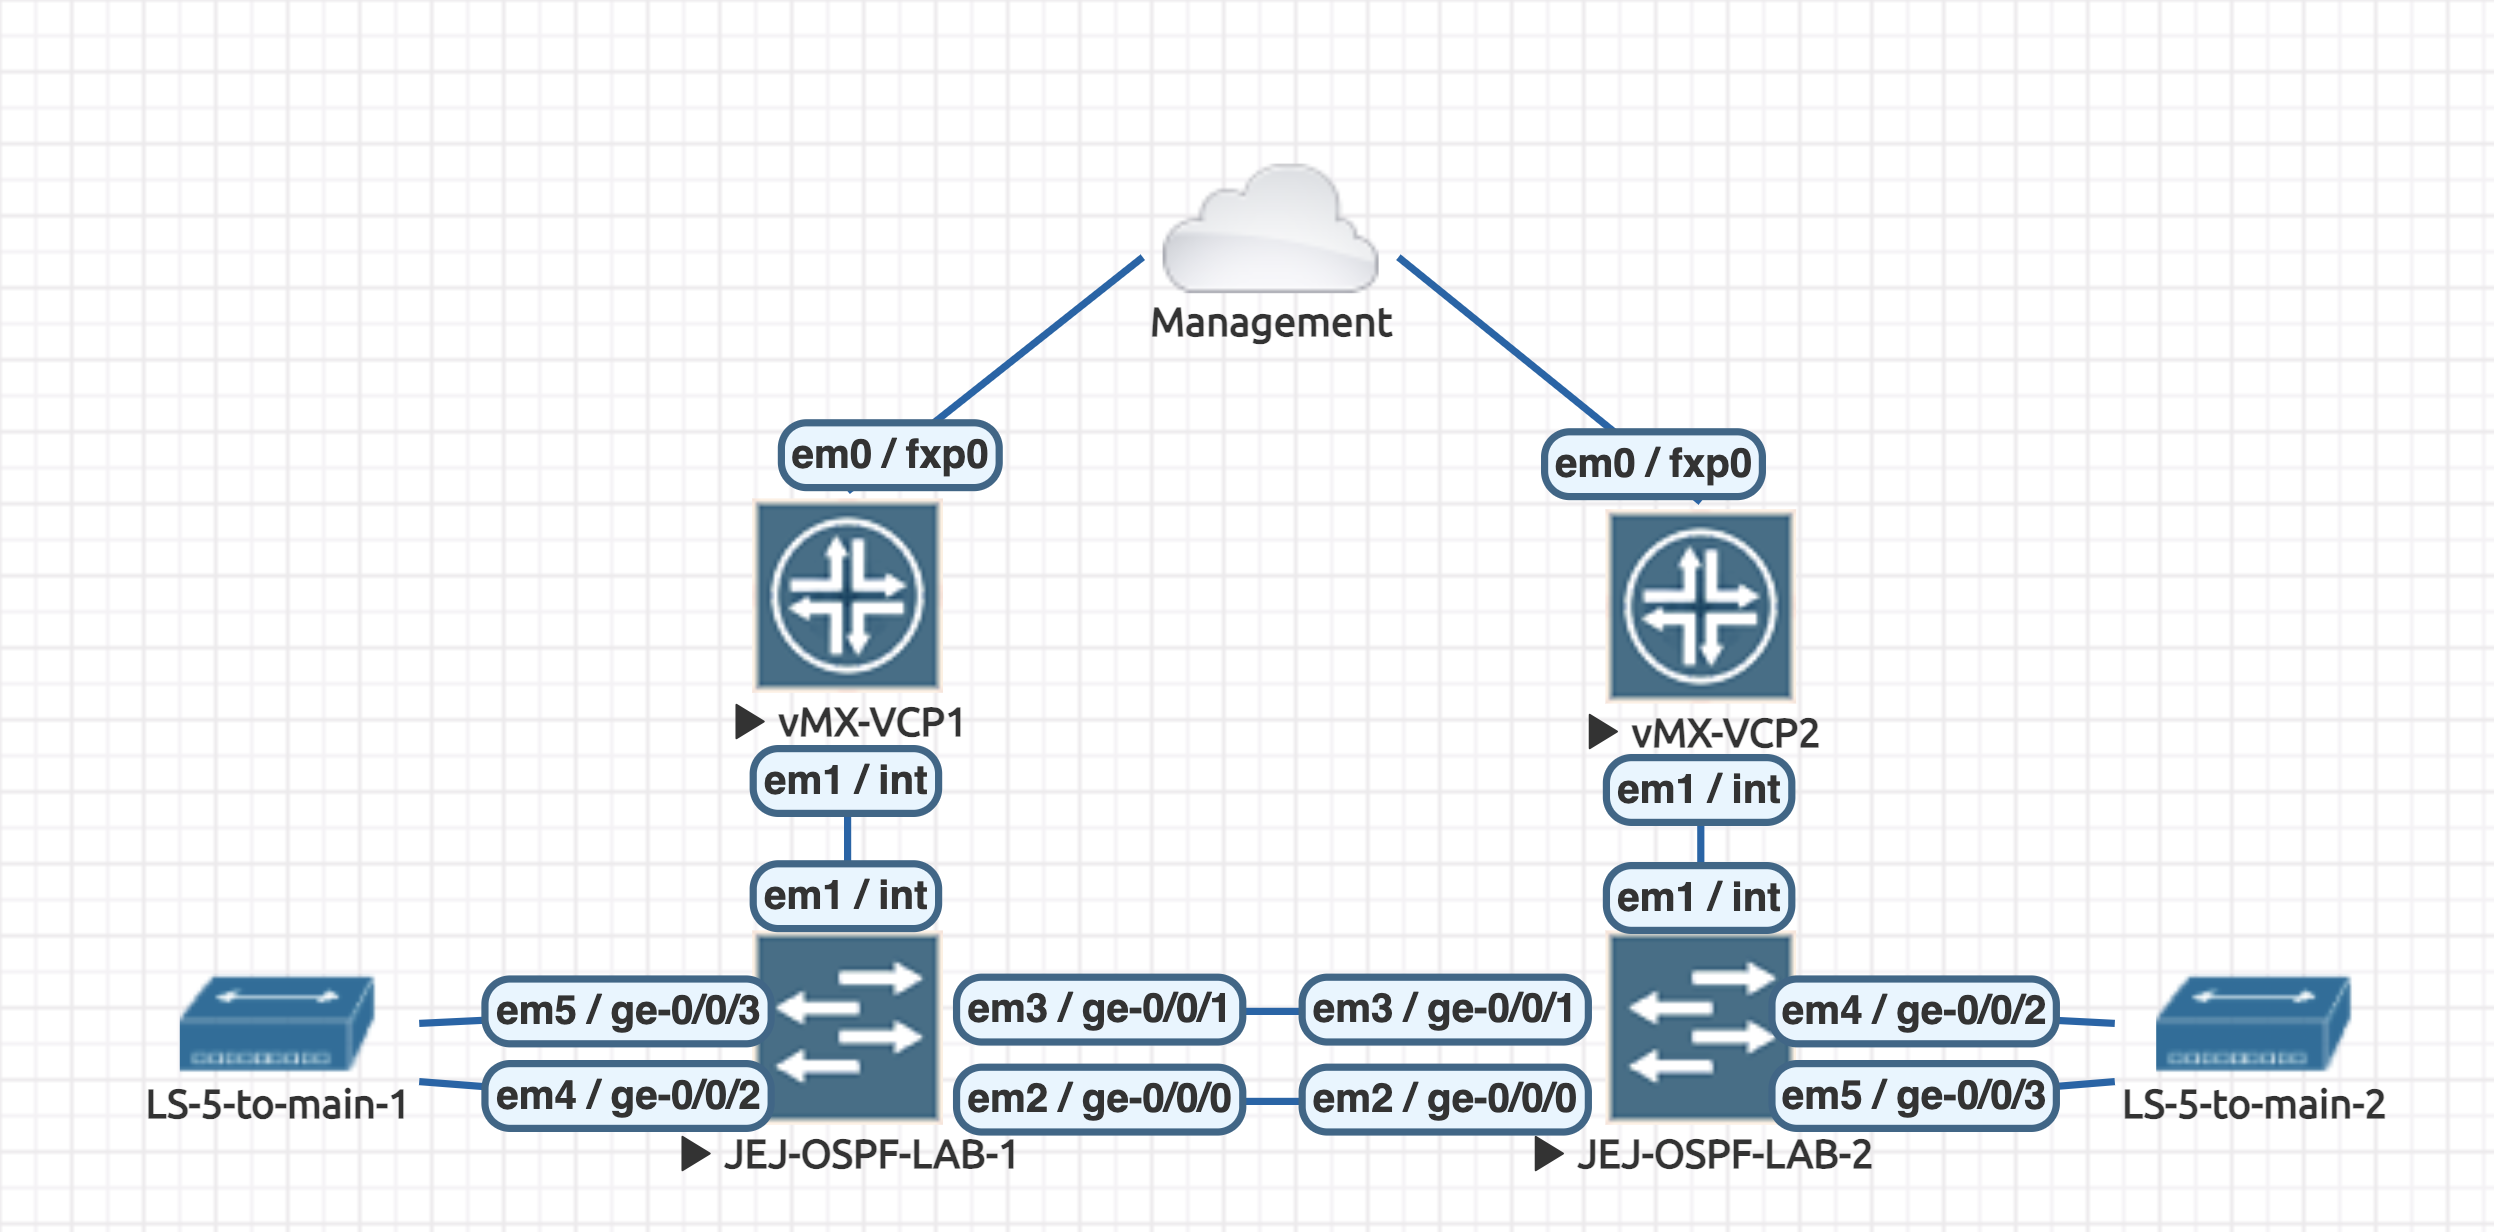

---

* Logical Diagram of logical systems and connection on vMX-OSPF-LAB-1 and vMX-OSPF-LAB-2.
* LS links on vMX-OSPF-LAB-1 will use the IP scheme 10.\<low>.\<high>.\<router_number>/24 for connecting links
    * Example: connection links addressing between LS-10 to LS-5 will be 10.5.10.10 and 10.5.10.5 respectively
* LS links on vMX-OSPF-LAB-2 will use the IP scheme 172.16\<high>\<low>.\<router_number>/24 for connecting links
    * Example: connection links addressing between LS-10 to LS-5 will be 172.16.105.10 and 172.16.105.5 respectively

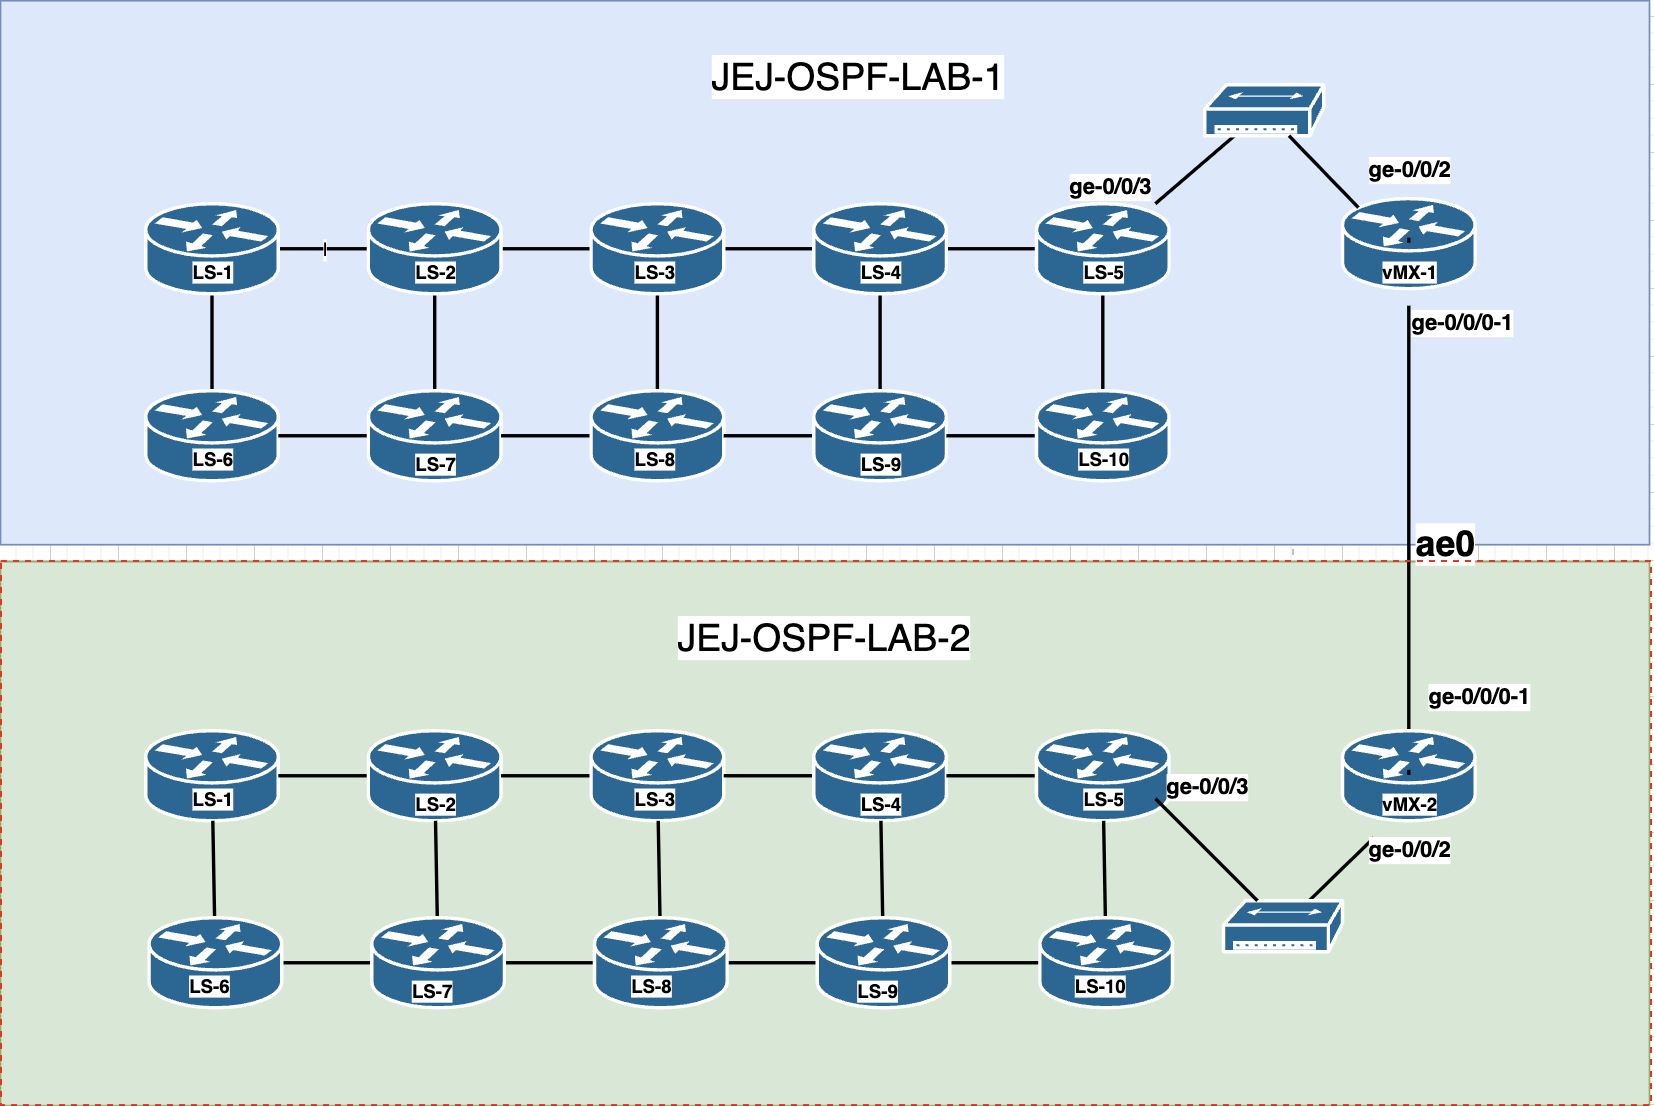


# Lab Setup

* import Nornir, with NAPALM driver
* import pynetbox to interface with Netbox to gather IP addressing info for the Logical-Systems

In [7]:
# Nornir imports and General Imports
import logging
import os
import yaml
from nornir import InitNornir
from nornir_utils.plugins.functions import print_result
from nornir_napalm.plugins.tasks import napalm_get, napalm_cli, napalm_configure
from nornir.core.task import Task, Result
from nornir.core.filter import F
from nornir_jinja2.plugins.tasks import template_string

jej_ospf_vmx_1_mgt_ip = "192.168.8.11"
jej_ospf_vmx_2_mgt_ip = "192.168.8.22"
mgmt_ips = [jej_ospf_vmx_1_mgt_ip, jej_ospf_vmx_2_mgt_ip]

In [8]:
# Pynetbox imports
import pynetbox
API_TOKEN=os.getenv("NETBOX_API_TOKEN")
url="http://localhost:8000"
nb = pynetbox.api(url, token=API_TOKEN)

# Generate hosts.yml file from Netbox
* Query Netbox to generate a hosts.yml file to be used with Nornir in the notebook
* I am sure there are better ways to do this, but just playing around for now 😉

In [9]:
vmxs = nb.dcim.devices.filter(device_type_id=2)
host_yaml_as_dict = {}
for device in vmxs:
    host_yaml_as_dict[device.name] = {}
    host_yaml_as_dict[device.name]['groups'] = [str(device.platform)]
    host_yaml_as_dict[device.name]['hostname'] = str(device.oob_ip).split("/")[0]
    host_yaml_as_dict[device.name]['data'] = {}
    host_yaml_as_dict[device.name]['data']["logical-systems"] = {}

In [79]:
devices = nb.dcim.devices.filter(device_type_id=3)
for device in devices:
    logical_system = str(device.name)
    vmx = "JEJ-OSPF-LAB-1" if logical_system.startswith("JEJ-OSPF-LAB-1") else "JEJ-OSPF-LAB-2" 
    interfaces = nb.dcim.interfaces.filter(device_id=device.id)
    host_yaml_as_dict[vmx]["data"]["logical-systems"][logical_system] = {}
    host_yaml_as_dict[vmx]["data"]["logical-systems"][logical_system]["logical-tunnels"] = {}
    host_yaml_as_dict[vmx]["data"]["logical-systems"][logical_system]["loopbacks"] = {}
    for interface in interfaces:
        ip_address = str(nb.ipam.ip_addresses.get(assigned_object_id=interface.id))
        interface_name = str(interface.name)
        if interface_name.startswith("lt"):
            ####################################################################################
            # Find the Peer side to use when configuring the LT interface
            # TODO: could I name these better? I am kinda amazed it worked in the first place
            # Code assumes point to point connections which is fine for the LT interfaces
            a_term = nb.dcim.cables.get(termination_a_id=interface.id)
            b_term = nb.dcim.cables.get(termination_b_id=interface.id)
            remote_interface =  a_term.b_terminations[0] if a_term else b_term.a_terminations[0]
            ####################################################################################
            
            host_yaml_as_dict[vmx]["data"]["logical-systems"][logical_system]["logical-tunnels"][interface_name] = {}
            host_yaml_as_dict[vmx]["data"]["logical-systems"][logical_system]["logical-tunnels"][interface_name]["ip"] = ip_address
            host_yaml_as_dict[vmx]["data"]["logical-systems"][logical_system]["logical-tunnels"][interface_name]["peer"] = str(remote_interface)
        elif interface_name.startswith("lo"): 
            host_yaml_as_dict[vmx]["data"]["logical-systems"][logical_system]["loopbacks"][interface_name] = ip_address
            

In [80]:
yaml_string = yaml.dump(host_yaml_as_dict, default_flow_style=False, sort_keys=False)
with open('./nornir_inventory/hosts.yml', 'w') as file:
    file.write("# hosts.yml\n")
    file.write("---\n")
    yaml.dump(host_yaml_as_dict, file, default_flow_style=False, sort_keys=False)
header = "'hosts.yml' file generated from Netbox Info to use with Nornir:"
header_delim = "-"*len(header)
print(header_delim); print(header); print(header_delim)
print(yaml_string)

---------------------------------------------------------------
'hosts.yml' file generated from Netbox Info to use with Nornir:
---------------------------------------------------------------
JEJ-OSPF-LAB-1:
  groups:
  - junos
  hostname: 192.168.8.41
  data:
    logical-systems:
      JEJ-OSPF-LAB-1-LS-1:
        logical-tunnels:
          lt-0/0/0.12:
            ip: 10.1.2.1/24
            peer: lt-0/0/0.21
          lt-0/0/0.16:
            ip: 10.1.6.1/24
            peer: lt-0/0/0.61
        loopbacks:
          lo0.1: 172.21.1.1/32
      JEJ-OSPF-LAB-1-LS-2:
        logical-tunnels:
          lt-0/0/0.21:
            ip: 10.1.2.2/24
            peer: lt-0/0/0.12
          lt-0/0/0.23:
            ip: 10.2.3.2/24
            peer: lt-0/0/0.32
          lt-0/0/0.27:
            ip: 10.2.7.2/24
            peer: lt-0/0/0.72
        loopbacks:
          lo0.2: 172.21.2.2/32
      JEJ-OSPF-LAB-1-LS-3:
        logical-tunnels:
          lt-0/0/0.32:
            ip: 10.2.3.3/24
      

## Back base config

In [76]:
#############################
# Backup/Restore  Functions #
#############################

def backup_all_configs(nr, backup_dir="backups", file_name_suffix=""):
    """Backs up running configurations from all devices in Nornir inventory."""
    os.makedirs(backup_dir, exist_ok=True)
    def backup_config(task):
        result = task.run(task=napalm_get, getters=["config"])
        config_data = result.result["config"]["running"]
        if not file_name_suffix:
            backup_filename = f"{backup_dir}/{task.host}_nornir_backup.conf"
        else:
            backup_filename = f"{backup_dir}/{task.host}_{file_name_suffix}_backup.conf"
        with open(backup_filename, "w") as backup_file:
            backup_file.write(config_data)
        print(f"Backup saved: {backup_filename}")
    nr.run(task=backup_config)

def restore_all_configs(nr, backup_dir="backups", file_name_suffix=""):
    """Restores all device configurations from the latest backup in the specified folder."""
    def restore_config(task):
        try:
            if not file_name_suffix:
                backup_filename = f"{backup_dir}/{task.host}_nornir_backup.conf"
            else:
                backup_filename = f"{backup_dir}/{task.host}_{file_name_suffix}_backup.conf"
            with open(backup_filename, "r") as file:
                config_data = file.read()
            task.run(task=napalm_configure, configuration=config_data, replace=True)
            print(f"Configuration restored for {task.host} from {backup_filename}")
        except Exception as err:
            print(f"No backup not found for {task.host}")
            print(err)
    nr.run(task=restore_config)

In [85]:
#backup_all_configs(nr, file_name_suffix="base")
restore_all_configs(nr, file_name_suffix="base")

Configuration restored for JEJ-OSPF-LAB-2 from backups/JEJ-OSPF-LAB-2_base_backup.conf
Configuration restored for JEJ-OSPF-LAB-1 from backups/JEJ-OSPF-LAB-1_base_backup.conf


## Configure OSPF with Nornir

In [86]:
nr = InitNornir(config_file="nornir_inventory/config.yml")

loopbacks_template = """
set chassis fpc 0 pic 0 tunnel-services 
{% for ls_name, ls_data in host.data['logical-systems'].items() %}
{% for loopback_interface, loopback_ip_address in ls_data['loopbacks'].items() %}
set logical-systems {{ ls_name }} interfaces {{ loopback_interface }} family inet address {{ loopback_ip_address }}
{% endfor %}
{% endfor %}

"""


def configure_ls_loopbacks(task):
    """Configure the loopbacks on the logical-systems"""
    template_result = task.run(
        task=template_string,
        template=loopbacks_template
    )
    config_commands = template_result.result.strip()
    if not config_commands:
        return Result(host=task.host, result="something is off...")
        
    apply_template = task.run(
        task=napalm_configure,
        configuration=config_commands,
        severity_level=logging.DEBUG,
    )
    return Result(host=task.host, result=f"Config applied:\n{config_commands}")

output = nr.run(task=configure_ls_loopbacks)

In [87]:
output

AggregatedResult (configure_ls_loopbacks): {'JEJ-OSPF-LAB-1': MultiResult: [Result: "configure_ls_loopbacks", Result: "template_string", Result: "napalm_configure"], 'JEJ-OSPF-LAB-2': MultiResult: [Result: "configure_ls_loopbacks", Result: "template_string", Result: "napalm_configure"]}

In [88]:
print_result(output, severity_level=logging.DEBUG)

configure_ls_loopbacks**********************************************************
* JEJ-OSPF-LAB-1 ** changed : True *********************************************
vvvv configure_ls_loopbacks ** changed : False vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv INFO
Config applied:
set chassis fpc 0 pic 0 tunnel-services 
set logical-systems JEJ-OSPF-LAB-1-LS-1 interfaces lo0.1 family inet address 172.21.1.1/32
set logical-systems JEJ-OSPF-LAB-1-LS-2 interfaces lo0.2 family inet address 172.21.2.2/32
set logical-systems JEJ-OSPF-LAB-1-LS-3 interfaces lo0.3 family inet address 172.21.3.3/32
set logical-systems JEJ-OSPF-LAB-1-LS-4 interfaces lo0.4 family inet address 172.21.4.4/32
set logical-systems JEJ-OSPF-LAB-1-LS-5 interfaces lo0.5 family inet address 172.21.5.5/32
set logical-systems JEJ-OSPF-LAB-1-LS-6 interfaces lo0.6 family inet address 172.21.6.6/32
set logical-systems JEJ-OSPF-LAB-1-LS-7 interfaces lo0.7 family inet address 172.21.7.7/32
set logical-systems JEJ-OSPF-LAB-1-LS-8 interfaces lo0.8 f